In [1]:
import torch
import numpy as np
import random
import os
def set_seed(seed):
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [2]:
! wget https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2022-06-25 04:48:30--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2022-06-25 04:48:30--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc77af120e69876d32593910a8b5.dl.dropboxusercontent.com/cd/0/inline/Bn1_HdhJ3VqvWkpcRzApPvQx8rUgYUwlDtiBCAiP8R8z05M869fB_HJ5LHnUj91KltKbki2XeeXBj8tVaX1bgENjvdLIOJYE45AR8D4uqCNfSE29rWHGzrhX_jGbudExZ_eS-UMa8h-lHt6MmZrErwqufHG1VFIotNmwXT0X-JK3tQ/file# [following]
--2022-06-25 04:48:30--  https://uc77af120e69876d32593910a8b5.dl.dropboxusercontent.com/cd/0/inline/Bn1_HdhJ3VqvWkpcRzApPvQx8rUgYUwlDtiBCAiP8R8z05M869fB_HJ5LHnUj9

In [3]:
!nvidia-smi


Sat Jun 25 04:48:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [40]:
images = []
lesions = []
from skimage.io import imread
from skimage.transform import resize
import os
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from PIL import Image
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [6]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [8]:
X.shape


(200, 256, 256, 3)

In [9]:
len(lesions)


200

In [ ]:
DATA_MODES = ['train', 'val', 'test']
class CancerDataset(Dataset):
    def __init__(self, images, lesions, mode):
        super().__init__()
        self.files = files
        self.lesions = lesions
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        aug_transform = transforms.Compose([ # трансформации для аугментации
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(8),                        
        ])
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = aug_transform(x)
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

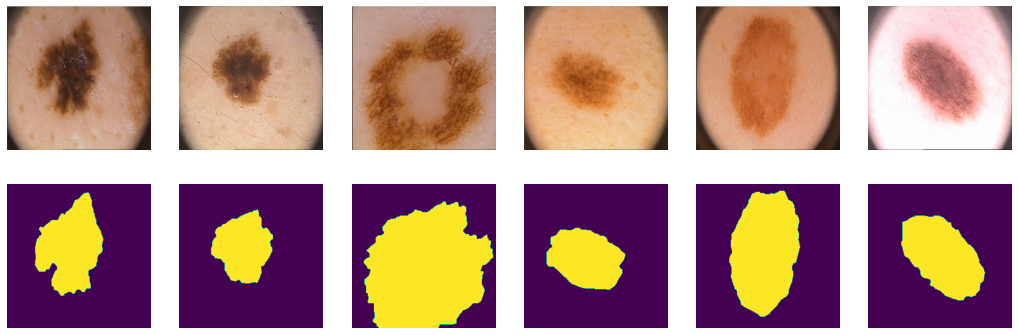

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [16]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [120, 160]) # разделим наши 200 картинок на трейн валидацию и тест

In [17]:
print(len(tr), len(val), len(ts))

120 40 40


In [18]:
from torch.utils.data import DataLoader
batch_size = 20
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True) #получается меняем с B x H x W x C
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True) #на B x C x H x W
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [21]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # если отправляем одну картинку, то сжимаем по внешней размерности
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    return iou

In [43]:
#посмотрим различные функции потерь
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred)))


def dice_loss(y_real, y_pred):
    num = 2*y_real*y_pred
    den = y_real + y_pred
    res = 1 - torch.sum(num/(den+1e-8))/256/256
    return res 


def focal_loss(y_real, y_pred, eps=1e-8, gamma=2): 
    y_pred =  torch.clamp(y_pred, eps, 1.0 - eps)
    first = (1.0-torch.sigmoid(y_pred))**gamma * y_real*torch.log(torch.sigmoid(y_pred))
    second = (1.0-y_real)*torch.log(1.0-torch.sigmoid(y_pred))
    loss = -torch.sum(first+second)
    return loss

def ssim_loss(y1, y2, win_size=8, channels=3, pad=3):
    C1 = 0.0001
    C2 = 0.0009
    window = torch.normal(win_size//2, 1.5, size = (win_size,win_size))
    window = window/window.sum()
    window = window.expand(1, channels, win_size, win_size)

    mu_y1 = F.conv2d(y1, window, padding=pad, groups=channels)
    mu_y2 = F.conv2d(y2, window, padding=pad, groups=channels)

    mu_y1_squared = mu_y1**2
    mu_y2_squared = mu_y2**2
    mu_y1y2 = mu_y1*mu_y2

    sigma_y1_squared = F.conv2d(y1 * y1, window, padding=pad, groups=channels) - mu_y1_squared
    sigma_y2_squared = F.conv2d(y2 * y2, window, padding=pad, groups=channels) - mu_y2_squared
    sigma_y1y2 =  F.conv2d(y1 * y2, window, padding=pad, groups=channels) - mu_y1y2

    contrast = (2*sigma_y1y2 + C2) / (sigma_y1_squared + sigma_y2_squared + C2).mean()
    ssim_loss = (2*mu_y1y2+C1)*(2*sigma_y1y2+C2) / ((mu_y1_squared+mu_y2_squared+C1)*(sigma_y1_squared+sigma_y2_squared + C2))
    return ssim_loss.mean()        

In [24]:
# определим архитектуру
def conv_layer(in_ch, out_ch, kernel, pad_size):
    layer = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size = kernel, padding = pad_size),
        nn.BatchNorm2d(num_features = out_ch),
        nn.ReLU()
    )
    return layer

def conv_block(in_list, out_list, kernel_list, padding_list):
    layers = [conv_layer(in_list[i], out_list[i],kernel_list[i], padding_list[i]) for i in range(len(in_list))]
    return nn.Sequential(*layers)

def deconv_layer(in_ch, out_ch, kernel, pad_size):
    layer = nn.Sequential(
        nn.Conv2d(in_ch,out_ch,kernel_size = kernel,padding = pad_size),
        nn.BatchNorm2d(num_features = out_ch),
        nn.ReLU()
    )
    return layer

def deconv_block(in_list, out_list, kernel_list, padding_list):
    layers = [deconv_layer(in_list[i], out_list[i],kernel_list[i], padding_list[i]) for i in range(len(in_list))]   
    return nn.Sequential(*layers)



class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices = True) # 256->128
        self.conv_layers_0 = conv_block([3,64,64],[64,64,64],[3,3,3],[1,1,1]) 
        self.conv_layers_1 = conv_block([64,128,128], [128,128,128], [3,3,3], [1,1,1]) 
        self.conv_layers_2 = conv_block([128,256], [256,256], [3,3], [1,1]) 
        self.conv_layers_3 = conv_block([256,512], [512,512], [3,3], [1,1]) 

        # bottleneck
        self.bottleneck_conv = conv_block([512,32,32],[32,32,512],[1,3,1],[0,1,0])

        # decoder
        self.unpool = nn.MaxUnpool2d(kernel_size = 2, stride = 2) # 16->32
        self.deconv_layer_3 = deconv_block([1024,512],[512,256],[3,3],[1,1]) 
        self.deconv_layer_2 = deconv_block([512,256],[256,128],[3,3],[1,1]) 
        self.deconv_layer_1 = deconv_block([256,128,128], [128,128,64], [3,3,3],[1,1,1]) 
        self.deconv_layer_0 = deconv_block([128,64,64], [64,64,1], [3,3,3],[1,1,1]) 

    def forward(self, x):
        # encoder
        e0 = self.conv_layers_0(x)
        e0p, ind_0 = self.pool(e0)
        e1 = self.conv_layers_1(e0p)
        e1p, ind_1 = self.pool(e1)
        e2 = self.conv_layers_2(e1p)
        e2p, ind_2 = self.pool(e2)
        e3 = self.conv_layers_3(e2p)
        e3p, ind_3 = self.pool(e3)

        # bottleneck
        b = self.bottleneck_conv(e3p)

        # decoder
        b = self.unpool(b, ind_3)
        d3 = self.unpool(self.deconv_layer_3(torch.cat((e3,b), axis = 1)), ind_2)
        d2 = self.unpool(self.deconv_layer_2(torch.cat((e2,d3), axis = 1)), ind_1)
        d1 = self.unpool(self.deconv_layer_1(torch.cat((e1,d2), axis = 1)), ind_0)
        d0 = self.deconv_layer_0(torch.cat((e0,d1),axis = 1)) # no activation
        return d0


def predict(model, data):
    model.eval()
    with torch.set_grad_enabled(False):
        Y_pred = model(data.to(device))
    return Y_pred

def score_model(model, metric, data):
    model.eval()
    with torch.set_grad_enabled(False):
        scores = 0
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device))
            Y_pred = torch.sigmoid(Y_pred)
            scores += metric(Y_pred.round(), Y_label.to(device))
    return (scores/len(data)).mean()


In [36]:
def train(model, opt, scheduler, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    train_loss_history = []
    val_loss_history = []
    score_history = []
    best_val_score = -1.0
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            scheduler.step()
            avg_loss += loss / len(data_tr)
        toc = time()
        train_loss_history.append(avg_loss.cpu().detach())
        print('train loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.set_grad_enabled(False):
            val_score = score_model(model, iou_pytorch, data_val)
            score_history.append(val_score.cpu())
            Y_hat = model(X_val.to(device)).to('cpu')
            val_loss = loss_fn(Y_val, Y_hat)
            val_loss_history.append(val_loss.cpu())
        print('score: %f' % val_score)
        if val_score > best_val_score:
            best_val_score = val_score
            best_Y_hat = Y_hat
            best_model_weights = model.state_dict()

            
        # для визуализации
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(best_Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - val_loss: %f   best_score: %f' % (epoch+1, epochs, val_loss, best_val_score))
        plt.show()
    
    plt_epochs = range(1,epochs+1)
    fig, ax = plt.subplots(1,2, sharex = True)

    ax[0].plot(plt_epochs, train_loss_history, label = 'train loss')
    ax[0].plot(plt_epochs, val_loss_history, label = 'val loss')
    ax[0].legend()
    ax[1].plot(plt_epochs, score_history, label = 'iou score')
    ax[1].legend()
    plt.show()
    
    model.load_state_dict(best_model_weights)
    return train_loss_history, val_loss_history, score_history, best_model_weights

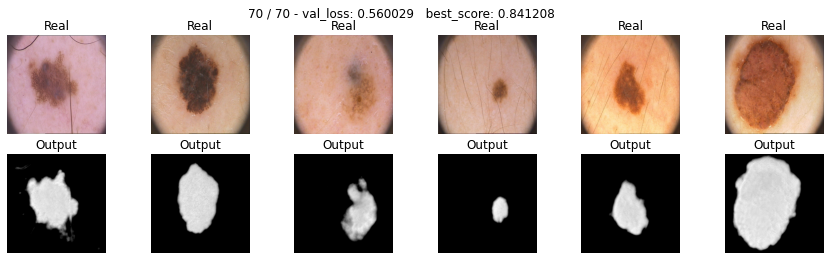

TypeError: ignored

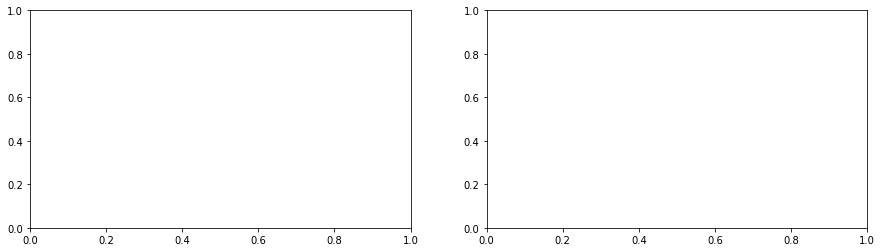

In [27]:
unet_bce = UNet().to(device)
max_epochs = 70
optim = torch.optim.Adam(unet_bce.parameters(), lr = 4e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=25, gamma = 0.7)
bce_unet_loss_train, bce_unet_loss_val, bce_unet_score, best_model_weights = train(
    unet_bce, optim, scheduler, bce_loss, max_epochs, data_tr, data_val
    )
print('Total score is:',score_model(unet_bce, iou_pytorch, data_val))

In [28]:
import gc
gc.collect()
torch.cuda.empty_cache()

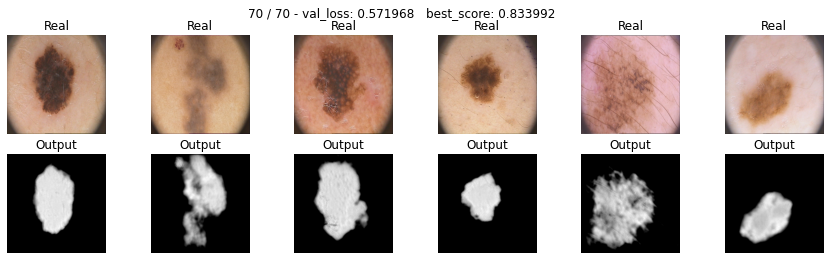

[tensor(0.6608), tensor(0.6075), tensor(0.5975), tensor(0.5936), tensor(0.5907), tensor(0.5860), tensor(0.5785), tensor(0.5814), tensor(0.5832), tensor(0.5820), tensor(0.5770), tensor(0.5737), tensor(0.5738), tensor(0.5732), tensor(0.5733), tensor(0.5688), tensor(0.5712), tensor(0.5721), tensor(0.5694), tensor(0.5708), tensor(0.5678), tensor(0.5648), tensor(0.5683), tensor(0.5637), tensor(0.5656), tensor(0.5676), tensor(0.5652), tensor(0.5637), tensor(0.5620), tensor(0.5604), tensor(0.5603), tensor(0.5592), tensor(0.5623), tensor(0.5618), tensor(0.5605), tensor(0.5628), tensor(0.5584), tensor(0.5581), tensor(0.5615), tensor(0.5631), tensor(0.5608), tensor(0.5590), tensor(0.5595), tensor(0.5601), tensor(0.5618), tensor(0.5680), tensor(0.5600), tensor(0.5603), tensor(0.5615), tensor(0.5602), tensor(0.5604), tensor(0.5576), tensor(0.5584), tensor(0.5595), tensor(0.5609), tensor(0.5572), tensor(0.5582), tensor(0.5614), tensor(0.5623), tensor(0.5585), tensor(0.5597), tensor(0.5603), tensor(

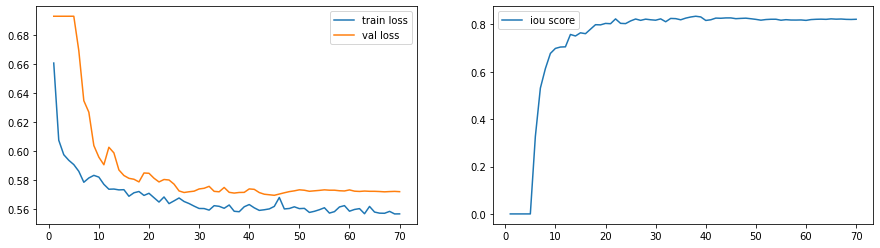

Total score is: tensor(0.8212, device='cuda:0')


In [39]:
unet_bce = UNet2().to(device)
max_epochs = 70
optim = torch.optim.Adam(unet_bce.parameters(), lr = 4e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=25, gamma = 0.7)
bce_unet_loss_train, bce_unet_loss_val, bce_unet_score, best_model_weights = train(
    unet_bce, optim, scheduler, bce_loss, max_epochs, data_tr, data_val
    )
print('Total score is:',score_model(unet_bce, iou_pytorch, data_val))

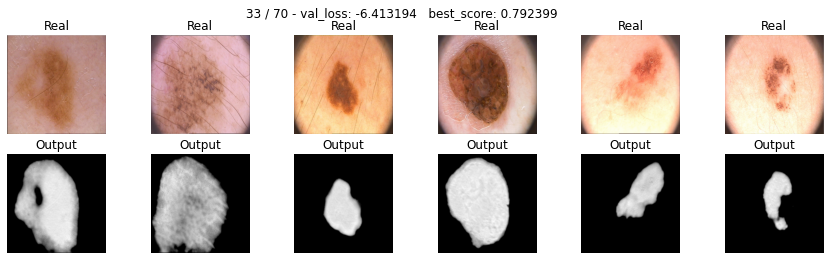

* Epoch 34/70


KeyboardInterrupt: ignored

In [45]:
unet_dice = UNet().to(device)
max_epochs = 70
optim = torch.optim.Adam(unet_dice.parameters(), lr = 4e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=25, gamma = 0.7)
dice_unet_loss_train, dice_unet_loss_val, dice_unet_score, best_model_weights = train(
    unet_dice, optim, scheduler, dice_loss, max_epochs, data_tr, data_val
    )
print('Total score is:',score_model(unet_dice, iou_pytorch, data_val))

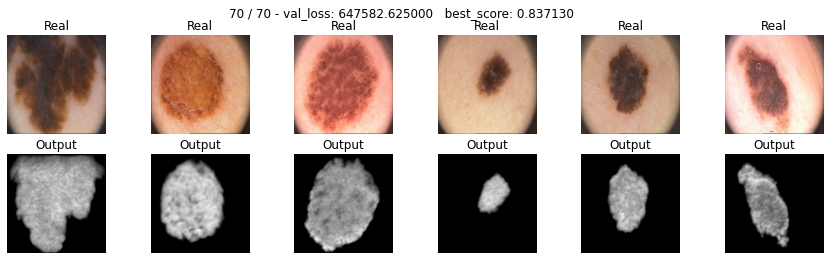

[tensor(717212.3125), tensor(668891.3750), tensor(663518.1250), tensor(660565.8750), tensor(660410.1875), tensor(661226.5000), tensor(659461.3750), tensor(657151.8750), tensor(656196.0625), tensor(656458.7500), tensor(656206.2500), tensor(655521.1875), tensor(659295.3750), tensor(653054.5625), tensor(653850.1875), tensor(652864.3750), tensor(655487.9375), tensor(652603.1250), tensor(651348.7500), tensor(655166.), tensor(651982.1875), tensor(650883.5000), tensor(651432.4375), tensor(650537.5000), tensor(652490.3750), tensor(651477.6250), tensor(650957.1875), tensor(649663.6250), tensor(648039.6250), tensor(647754.8125), tensor(648512.3125), tensor(649065.5000), tensor(646836.8750), tensor(646138.5000), tensor(647071.2500), tensor(646416.6250), tensor(645443.), tensor(645438.5000), tensor(645386.5000), tensor(644314.1250), tensor(644108.2500), tensor(645605.6875), tensor(645617.5625), tensor(644552.7500), tensor(644516.5000), tensor(644941.4375), tensor(644402.4375), tensor(647159.9375),

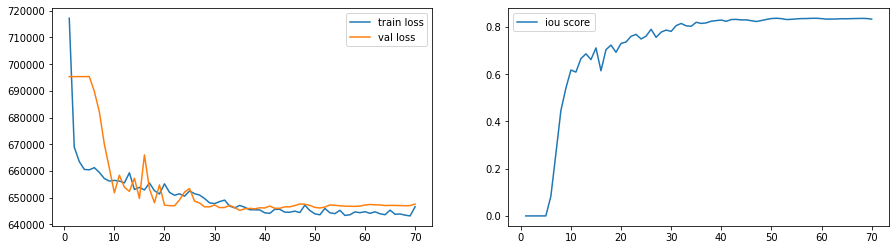

Total score is: tensor(0.8333, device='cuda:0')


In [46]:
#focal
unet_dice = UNet().to(device)
max_epochs = 70
optim = torch.optim.Adam(unet_dice.parameters(), lr = 4e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=25, gamma = 0.7)
dice_unet_loss_train, dice_unet_loss_val, dice_unet_score, best_model_weights = train(
    unet_dice, optim, scheduler, focal_loss, max_epochs, data_tr, data_val
    )
print('Total score is:',score_model(unet_dice, iou_pytorch, data_val))